# Análisis Final, Cuellos de Botella V.2

Se procede a realizar el análisis final del proyecto, en donde se incorporarán las demás zonas operacionales que quedan pendientes.
Las tareas pendientes son: 

1. Analizar el tiempo promedio, min y máx para los tiempos de espera antes de entrar a la cancha. (Listo en V1)
2. Calcular el tiempo de espera perdido utilizando el tiempo calculado anteriormente. (Listo en V1)
3. Analizar las zonas restantes teniendo en cuenta el canchas y meses.
4. Analisis de monetización por tramo-Producto
5. Análisis de monetización romanas

__pd el dataset de colas tiene el filtro de las colas inferiores a 3 hrs__
# 3. Analizar las zonas restantes teniendo en cuenta el producto, origen, destino.

Para ello necesitamos los siguientes gráficos.

1. Promedios y Peaks de Actividad y Cola (juntos) con los datos sin parcelar.
2. Análisis Colas por camion, minutos y minutos/camión.

### 1. Promedios y Peaks de Actividad y Cola (juntos) con los datos sin parcelar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns
from manager_propio import *

from subprocess import call 

def clear(): 
    # check and make call for specific operating system 
    _ = call('clear' if os.name =='posix' else 'cls') 

In [2]:
cols = ['Total Time','Datei','Datef','Ti','Tf']

#Cargamos el dataset de actividades
actividad = pd.read_csv('actividad_v2.csv')
actividad = actividad.drop('Unnamed: 0',axis=1)
#actividad = actividad.drop(cols,axis=1)
actividad['Start Act'] = pd.to_datetime(actividad['Start Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['End Act'] = pd.to_datetime(actividad['End Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['date start'] = pd.to_datetime(actividad['Start Act']).dt.date
actividad['date end'] = pd.to_datetime(actividad['End Act']).dt.date
actividad['time start'] = pd.to_datetime(actividad['Start Act']).dt.time
actividad['time end'] = pd.to_datetime(actividad['End Act']).dt.time
actividad['Day of year [In]'] = pd.to_datetime(actividad['Start Act']).dt.dayofyear
actividad['Day of year [Out]'] = pd.to_datetime(actividad['End Act']).dt.dayofyear
actividad['time Act'] = ((actividad['End Act']) - pd.to_datetime(actividad['Start Act']))/np.timedelta64(1, 's')

#cargamos el dataset de las colas antiguas
colas_old = pd.read_csv('colas.csv')
colas_old = colas_old.drop('Unnamed: 0',axis=1)
colas_old['Start Cola'] = pd.to_datetime(colas_old['Start Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['End Cola'] = pd.to_datetime(colas_old['End Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['date start'] = pd.to_datetime(colas_old['Start Cola']).dt.date
colas_old['date end'] = pd.to_datetime(colas_old['End Cola']).dt.date
colas_old['time start'] = pd.to_datetime(colas_old['Start Cola']).dt.time
colas_old['time end'] = pd.to_datetime(colas_old['End Cola']).dt.time
colas_old['Day of year [In]'] = pd.to_datetime(colas_old['Start Cola']).dt.dayofyear
colas_old['Day of year [Out]'] = pd.to_datetime(colas_old['End Cola']).dt.dayofyear
colas_old['time cola'] = ((colas_old['End Cola']) - pd.to_datetime(colas_old['Start Cola']))/np.timedelta64(1, 's')

#Filtramos por el termino de las 3 hrs
colas_old = colas_old[(colas_old['time cola'] < 10800) & (colas_old['time cola'] > 0)]  #timepos mayores a 0 minutos y menores a 3 hrs


#Cargamos el dataset de las nuevas colas. con el filtro de las 3 horas
colas = pd.read_csv("colas_filtradas_v2.csv")  #ya tiene las horas cambiadas
colas = colas.drop('Unnamed: 0',axis=1)
colas['Start Cola'] = pd.to_datetime(colas['Start Cola'])
colas['End Cola'] = pd.to_datetime(colas['End Cola'])

## Peaks y Promedios

Analizaremos Sin tramos de preferencia primero.

In [3]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_del_año = dict(zip(meses, dias_mes)) 
zonas_totales = ['C Secado L-3','C NPT3','C Prilado','Romana Mto','Romana Salitre','C ATM','Losa Envasado','Galpones','C NPT4',
         'C CS-11','Romana 3','C CS-12','C PTS','C Secado L-4','C CS-P.Valdivia','C CS-4','C NPT 1-2','C Granulacion']

In [4]:
def plot_colas_act_2(df1,df2,zone,title,file):
    min1 = int(df1[zone].min())
    min2 = int(df2[zone].min())
    max1 = int(df1[zone].max()+1)
    max2 = int(df2[zone].max()+1)
    minimum = min(min1,min2)
    maximum = max(max1,max2)
    
    plt.figure(figsize=(30,15))
    plt.plot(df1[zone],'bo--',lw=3,label='Cola E')
    plt.plot(df2[zone],'ro--',lw=3,label='Actividad')
    plt.title(title,fontsize=30)
    plt.xlabel("horas",fontsize=25)
    plt.ylabel("Camiones/hr",fontsize=25)
    plt.xticks(np.arange(1,25,1),fontsize=20)
    plt.yticks(np.arange(minimum,maximum,1),fontsize=20)
    #plt.axvline(x=17,lw=5,c='g')
    #plt.axvline(x=5,lw=5,c='g')

    #plt.fill_between((4,6), min1, max1,color='gray', alpha=0.3)
    plt.legend(fontsize=15)
    plt.grid(True)
    #plt.fill_between((16,18),min1, max1,color='gray', alpha=0.3)
    plt.savefig(file)
    plt.close()
    #plt.show()

In [5]:
# metrica = ['max','mean']
# for i in metrica:
#     for mes in meses:
#         print(mes, i)
#         print(meses_del_año[mes][0],meses_del_año[mes][1])
#         prom_act = analisis_por_dia(actividad,meses_del_año[mes][0],meses_del_año[mes][1],1,25,None,condicion='end',metric=i)
#         prom_cola = analisis_por_dia(colas_old,meses_del_año[mes][0],meses_del_año[mes][1],1,25,None,condicion='end',metric=i)
#         prom_act.to_csv("./actividad_cola/Sin_tramos/meses/prom_actividad_" + i + "_" + mes + ".csv")
#         prom_cola.to_csv("./actividad_cola/Sin_tramos/meses/prom_colas_" + i + "_" + mes + ".csv")
#         for zona in zonas_totales:
#             print(mes, zona)
#             #creamos el plot
#             nombre_archivo = "./actividad_cola/Sin_tramos/meses/colas_actividad_" + i + "_" + mes + "_" + zona + ".png"
#             titulo = mes+": promedio camiones " + zona
#             plot_colas_act_2(prom_cola,prom_act,zone=zona,title=titulo,file=nombre_archivo)

In [6]:
# # cargamos los datos y graficamos los peaks 
# for mes in meses:
#     aux_1 = pd.read_csv("./actividad_cola/Sin_tramos/meses/prom_actividad_max_" + mes + ".csv")
#     aux_1 = aux_1.set_index(np.arange(1,25,1))
#     aux_2 = pd.read_csv("./actividad_cola/Sin_tramos/meses/prom_colas_max_" + mes + ".csv").set_index(np.arange(1,25,1))

#     for zona in zonas_totales:
#             nombre_archivo = "./actividad_cola/Sin_tramos/meses/colas_actividad_max_" + mes + "_" + zona + ".png"
#             titulo = mes+": peaks camiones " + zona
#             plot_colas_act_2(aux_2,aux_1,zone=zona,title=titulo,file=nombre_archivo)

# 2. Análisis minutos Cola por mes.

In [7]:
def plot_minutos_totales(df,title,file=None):    
    min1 = int(df['minutos/camion'].min())
    min2 = int(df['minutos'].min())
    max1 = int(df['minutos/camion'].max()+5)
    max2 = int(df['minutos'].max()+5)
    gap =  int((max1-min1)/15)
    gap_2= int((max2-min2)/15)
    if gap == 0:
        gap = 1
    if gap_2 == 0:
        gap_2 = 1
    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title,fontsize=25)
    plt.grid(True,alpha=0.4)

    ax.set_xlabel('Horas',fontsize=20)
    ax.set_ylabel('Min/camion',fontsize=20, color='black')
    line1 = ax.plot(df['block'], df['minutos/camion'],marker='o',linestyle='-',lw=3, color='red',label='min/truck')
    line3 = ax.bar(df['block'],df['camiones'],width=0.5, color='blue',align='center')
    ax.legend(["trucks"],loc='upper left')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticks(np.arange(1,25,1))
    ax.set_xticklabels(np.arange(1,25,1),fontsize=15)
    ax.set_yticks(np.arange(0,max1,gap))
    ax.set_yticklabels(np.arange(0,max1,gap),fontsize=15)
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Minutos', fontsize=20, color='black')  # we already handled the x-label with ax1
    line2 = ax2.plot(df['block'],df['minutos'],marker='o',linestyle='--',lw=3,color='green',label='Minutos totales')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_yticks(np.arange(0,max2,gap_2))
    ax2.set_yticklabels(np.arange(0,max2,gap_2),fontsize=15)
    ax2.fill_between(df['block'],df['minutos'],alpha=0.3)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # added these two lines
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    #print(lns)
    ax.legend(lns, labs, loc=0,fontsize=20)
    if file != None: 
        plt.savefig(file)
    plt.close()
    #plt.show()

def stack_by_day_2(df,zone,dia_inicial,dia_final,metric='max',name=None,origen=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    if (origen != None):
        df = df[df['Origin'] == origen]
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux,_ = convert_df_to_df(df,zone,i)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0)

In [8]:
from IPython.display import clear_output

#creamos todos los plots necesarios para el promedio.
# for mes in meses_del_año:
#     for zona in zonas_totales:
#         print(zona,mes)
#         #print(meses_del_año[mes][0],meses_del_año[mes][1])
#         b_1 = stack_by_day_2(colas,zona,meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
#         b_1['minutos'] = b_1['minutos/camion']*b_1['camiones']
#         title = mes + " : analisis Colas en cancha " + zona
#         file = "./colas_finales/" + mes + "/colas_minutos_" + mes + "_" + zona + ".png"
#         plot_minutos_totales(b_1,title,file=None)
#         clear_output(wait=True)
# cargamos los datos y graficamos los peaks 
# for mes in meses:
#     aux_1 = pd.read_csv("./actividad_cola/Sin_tramos/meses/prom_actividad_max_" + mes + ".csv")
#     aux_1 = aux_1.set_index(np.arange(1,25,1))
#     aux_2 = pd.read_csv("./actividad_cola/Sin_tramos/meses/prom_colas_max_" + mes + ".csv").set_index(np.arange(1,25,1))

#     for zona in zonas_totales:
#             nombre_archivo = "./actividad_cola/Sin_tramos/meses/colas_actividad_max_" + mes + "_" + zona + ".png"
#             titulo = mes+": peaks camiones " + zona
#             plot_colas_act_2(aux_2,aux_1,zone=zona,title=titulo,file=nombre_archivo)

## 3. Comparativa NPT3, CS-4 Y NPT4

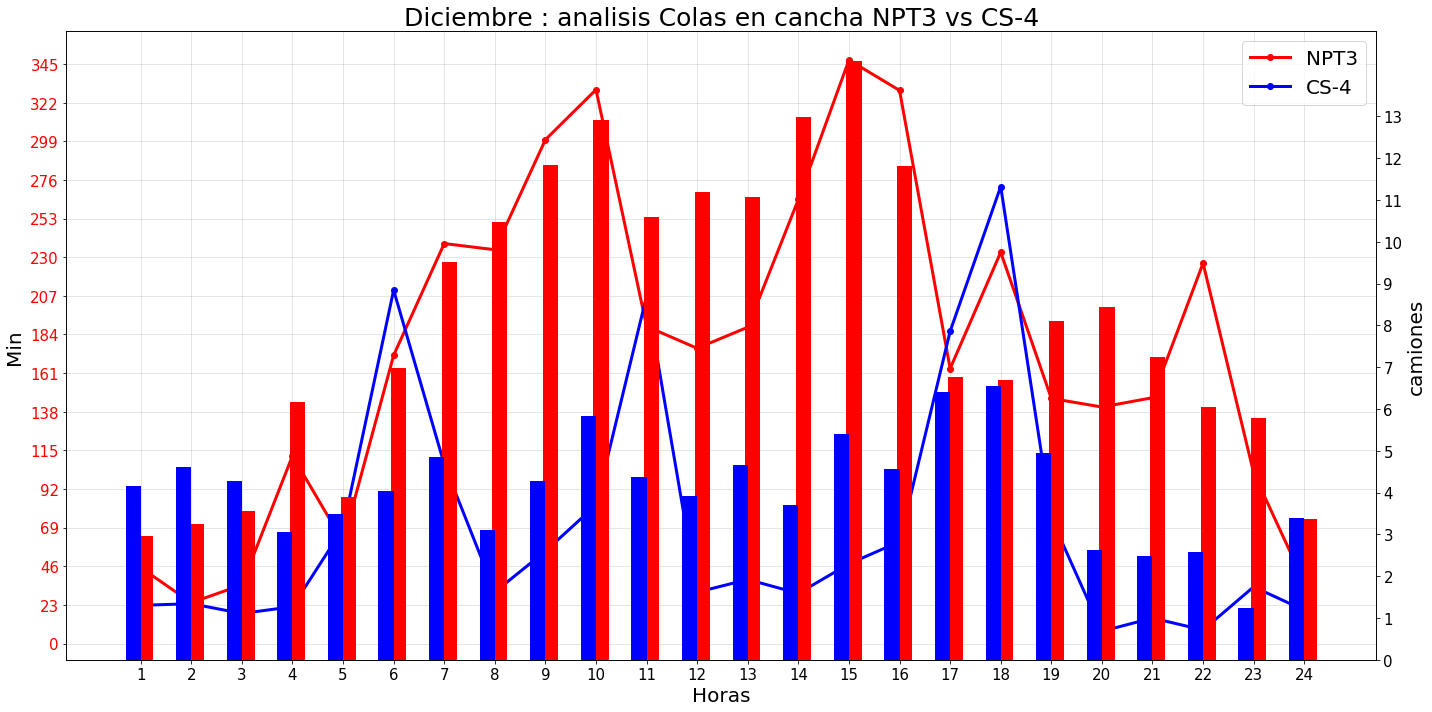

In [9]:
from IPython.display import clear_output

for mes in meses_del_año:
    clear_output(wait=True)

    a = stack_by_day_2(colas,'C NPT3',meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
    a['minutos'] = a['minutos/camion']*a['camiones']

    b = stack_by_day_2(colas,'C CS-4',meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
    b['minutos'] = b['minutos/camion']*b['camiones']

    c = stack_by_day_2(colas,'C NPT4',meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
    c['minutos'] = c['minutos/camion']*c['camiones']

    title = mes + " : analisis Colas en cancha NPT3 vs CS-4"
    file = "./colas_finales/NPT3-CS4/colas_minutos_" + mes +"NPT3_CS4.png"


    min1 = int(min(a['camiones'].min(),b['camiones'].min(),c['camiones'].min()))
    min2 = int(min(a['minutos'].min(),b['minutos'].min(),c['minutos'].min()))
    max1 = int(max(a['camiones'].max(),b['camiones'].max(),c['camiones'].max()))
    max2 = int(max(a['minutos'].max(),b['minutos'].max(),c['minutos'].max()))
    gap =  int((max1-min1)/15)
    gap_2= int((max2-min2)/15)
    if gap == 0:
        gap = 1
    if gap_2 == 0:
        gap_2 = 1

    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title,fontsize=25)
    plt.grid(True,alpha=0.4)

    ax.set_xlabel('Horas',fontsize=20)
    ax.set_ylabel('Min ',fontsize=20, color='black')
    line1 = ax.plot(a['block'], a['minutos'],marker='o',linestyle='-',lw=3, color='red',label='NPT3')
    line2 = ax.plot(b['block'], b['minutos'],marker='o',linestyle='-',lw=3, color='blue',label='CS-4')
    #line3 = ax.plot(c['block'], c['minutos'],marker='o',linestyle='-',lw=3, color='blue',label='NPT4')
    #ax.fill_between(a['block'],a['minutos'],alpha=0.5,color='red')
    #ax.fill_between(b['block'],b['camiones'],alpha=0.5,color='green')
    #ax.fill_between(c['block'],c['camiones'],alpha=0.5,color='blue')

    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticks(np.arange(1,25,1))
    ax.set_xticklabels(np.arange(1,25,1),fontsize=15)
    ax.set_yticks(np.arange(0,max2,gap_2))
    ax.set_yticklabels(np.arange(0,max2,gap_2),fontsize=15)

    ax2 = ax.twinx()  # same x-axis

    ax2.set_ylabel('camiones', fontsize=20, color='black')  # we already handled the x-label with ax1

    ax2.bar(a['block']+0.1, a['camiones'],width=0.3, color='red',align='center')
    ax2.bar(b['block']-0.3, b['camiones'],width=0.3, color='blue',align='edge')
    #ax2.bar(c['block']+0.3, c['camiones'],width=0.3, color='blue',align='edge')

    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_yticks(np.arange(0,max1,gap))
    ax2.set_yticklabels(np.arange(0,max1,gap),fontsize=15)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # added these two lines
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0,fontsize=20)
#     if file != None: 
#         plt.savefig(file)
    plt.show()

## 4. Monetización por Tramo y producto

Limpiamos el contenido de la variable producto para un mejor tratamiento.

In [10]:
#snit
colas = colas.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
colas_old = colas_old.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
#moph-silvinita
colas = colas.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA'],
        'MOP-H-BL | SILVINITA')
colas_old = colas_old.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA'],
        'MOP-H-BL | SILVINITA')

#moph
colas = colas.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')
colas_old = colas_old.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')

#duplicados
colas = colas.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS'])
colas_old = colas_old.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS'])

colas = colas.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
colas_old = colas_old.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
#########################################333
#actividad
#snit
actividad = actividad.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
#moph-silvinita
actividad = actividad.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
        'SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL', ],
        'MOP-H-BL | SILVINITA')


#moph
actividad = actividad.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')
#duplicados
actividad = actividad.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS','SILVINITA | SILVINITA'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS','SILVINITA'])

actividad = actividad.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
actividad = actividad.replace(['NPC-TA 50 H | SPO | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | NK 15-0-2 | NK 15-0-2'],
                             'NPC-TA 50 H | SPO | SSI | NK 15-0-2')

# MOnetización
## Encontrando los tiempos ideales

In [11]:
def found_time(trayecto,romanas=False):
    if romanas == False: # no utilizamos las romanas
        aux = actividad[~((actividad['Origin'] == 'Coya Sur') & (actividad['Destination'] == 'Coya Sur'))]
        aux = aux[(aux['ZO']!='Romana Salitre') & (aux['ZO']!='Romana Mto') & (aux['ZO']!='Romana 3')]
    else:
        aux = actividad[~((actividad['Origin'] == 'Coya Sur') & (actividad['Destination'] == 'Coya Sur'))]
    df_aux = aux[((aux['Origin'] == trayecto) | (aux['Origin'] == 'Coya Sur')) & 
                      ((aux['Destination'] == trayecto) | (aux['Destination'] == 'Coya Sur'))]
    #A la 1era ZO.
    a = df_aux[(df_aux['ZO'] != 'Salida') & (df_aux['Pre Time'] <= 1500) & (df_aux['time start'] <= datetime.time(3,0,0))].describe()
    b = df_aux[(df_aux['ZO'] == 'Salida') & (df_aux['time start'] <= datetime.time(3,0,0))].describe()
    #print("Tiempo desde la entrada : ",round(a.iloc[5,0]/60,1), " minutos")
    #print("Tiempo de actividad en la ZO : ",round(a.iloc[5,3]/60,1), " minutos")
    #print("Tiempo desde la ZO a la Salida: ",round(b.iloc[1,3]/60,1), " minutos")
    tiempo_real = round(a.iloc[5,0]/60,1) + (2*round(a.iloc[5,3]/60,1))+6
    print("El tiempo a utilizar para este trayecto, " + trayecto +" será: ", tiempo_real, " minutos")
    productos = df_aux.Product.unique().tolist()
    print("Los productos que tiene este trayecto son: ",productos )
    delete=[]
    #for i in productos:
        #print(i, df_aux[df_aux['Product']==i].shape[0])
    #    if df_aux[df_aux['Product']==i].shape[0] < 1000:
    #        delete.append(i)
    #productos = [x for x in productos if x not in delete]
    productos = [x for x in productos if x == x]
    ## filtro por productos
    prod_final = []
    for i in productos:
        df_aux_2 = df_aux[df_aux['Product']==i]
        a_ = df_aux_2[(df_aux_2['ZO'] != 'Salida') & (df_aux_2['Pre Time'] <= 1500) & (df_aux_2['time start'] <= datetime.time(3,0,0))].describe()
        tiempo_real_ = round(a_.iloc[5,0]/60,1) + (2*round(a_.iloc[5,3]/60,1))+6
        print("El tiempo a utilizar para esta ZO y el producto "+i+" será: ", tiempo_real_, " minutos")
        prod_final.append([i,tiempo_real])
    print("")
    return prod_final

In [12]:
trayectos = ['Salar de Atacama','Nueva Victoria','Tocopilla','Puerto Angamos','Cerro Dominador']
for i in trayectos:
    found_time(i)

El tiempo a utilizar para este trayecto, Salar de Atacama será:  35.4  minutos
Los productos que tiene este trayecto son:  ['MOP-H-BL', 'SILVINITA', nan, 'MOP-H-AL', 'SOP-H', 'MOP TALCO', 'MOP-H-BL | SILVINITA']
El tiempo a utilizar para esta ZO y el producto MOP-H-BL será:  36.3  minutos
El tiempo a utilizar para esta ZO y el producto SILVINITA será:  34.5  minutos
El tiempo a utilizar para esta ZO y el producto MOP-H-AL será:  nan  minutos
El tiempo a utilizar para esta ZO y el producto SOP-H será:  nan  minutos
El tiempo a utilizar para esta ZO y el producto MOP TALCO será:  63.8  minutos
El tiempo a utilizar para esta ZO y el producto MOP-H-BL | SILVINITA será:  nan  minutos

El tiempo a utilizar para este trayecto, Nueva Victoria será:  32.8  minutos
Los productos que tiene este trayecto son:  [nan, 'SNIT']
El tiempo a utilizar para esta ZO y el producto SNIT será:  32.9  minutos

El tiempo a utilizar para este trayecto, Tocopilla será:  27.6  minutos
Los productos que tiene este 

## Procedemos a monetizar 

In [13]:
def block(df,date_inicial,date_final,time_inicial,time_final,condicion=0):
    """ A grandes rasgos esto es lo que hace la función block_generator parra el dataset original"""
    if condicion == 'start':
        df = df[(df['Day of year [In]'] >= date_inicial)  & (df['Day of year [In]'] <= date_final) & (df['time start'] >= time_inicial) & (df['time start'] <= time_final)]
    elif condicion == 'end':
        df = df[(df['Day of year [Out]'] >= date_inicial)  & (df['Day of year [Out]'] <= date_final) & (df['time end'] >= time_inicial) & (df['time end'] <= time_final)]
    else:
        print("ingrese una opcion valida, 'start' o 'end', se devuelve el df incial ")
    return df


def vehiculos_cola(df,date_inicial,date_final,inicio=1,fin=25,condition='end'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos en ella} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]

        time_start = datetime.time(start[0], start[1], start[2])
        time_end = datetime.time(end[0], end[1], end[2])
        df_ = block(df,date_inicial,date_final,time_start,time_end,condition)
        
        for zo in df_['ZO'].unique().tolist(): 
            block_filtered = df_[df_['ZO'] == zo]
            vehiculos_in = block_filtered.shape[0]
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    diccionario[zo].update({i:vehiculos_in})
                else:
                    diccionario.update({zo:{i:vehiculos_in}})
    return diccionario

def analisis_por_dia_2(df,dia_inicial,dia_final,hora_incial=1,hora_final=25,name=None,condicion='end',metric='max',zonas=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux = dict_to_df_2(vehiculos_cola(df,i,i,1,25,condicion),zonas_totales)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0)

def dict_to_df_2(dictionary,zonas=None):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    if zonas == None:
        zonas = ['Romana Salitre', 'C Secado L-4', 'C PTS', 'C NPT3', 'Romana Mto', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
                 'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'Romana 3', 'C CS-11']
    test = np.arange(1,25,1)
    count=0
    #print(dictionary.items(), len(dictionary.items()))
    if len(dictionary.items()) == 0 :
        dictionary = {'C NPT3':{0:0}}
    for k, v in dictionary.items():
        
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        for i in test:
            if i not in a.index:
                #print("no esta este indice", i)
                a.loc[i] = 0.
        a = a.sort_index(axis=0)
        if (count == 0):
            b = a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0.)
    cols_b = b.keys().tolist()
    diff = list(set(zonas) - set(cols_b))
    if (len(diff) > 0):
        for i in diff:
            b[i] = 0.
    
    b = b.reindex(sorted(b.columns), axis=1)
    return b

#Parametros
toneladas = 29.5
price_min = 9500 
price_max = 13000
hr_job = 16
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_del_año = dict(zip(meses, dias_mes)) 


def monetizacion(df,df_,zona,dia,fin=None,tiempo_ideal=35,zonas=None):
    """Entrega las horas perdidas, camiones perdidos y dinero max y min perdido para un
    determinado tiempo y zona operacional"""
        
    if fin == None:
        fin = dia+1
    else:
        fin +=1
    for i in range(dia,fin): 
        prom_cola = analisis_por_dia_2(df,i,i,1,25,None,condicion='end',metric='mean',zonas=zonas)
        a = stack_by_day(df_,zona,i,i,metric='mean')
        a['minutos'] = a['minutos/camion']*a['camiones']

        #calculo de dif_time
        dif_time = pd.concat([a[['block','minutos']],prom_cola[zona]],axis=1)
        dif_time["diferencia"] = dif_time['minutos']- dif_time[zona]*tiempo_ideal
        dif_time.loc[dif_time['diferencia'] < 0, 'diferencia'] = 0   

        #MONETIZACIÓN
        horas = (dif_time['diferencia'].sum())/60.
        camiones = horas/hr_job
        precio_minimo = (camiones * toneladas * price_min)/1000000.
        precio_maximo = (camiones * toneladas * price_max)/1000000.

        if i == dia:
            atributos = [horas,camiones,precio_minimo,precio_maximo]
        else:
            atributos = [horas+atributos[0],camiones+atributos[1],precio_minimo+atributos[2],precio_maximo+atributos[3]]
    return atributos


In [14]:
#Quitamos febrero
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_2020 = ['Enero','Febrero','Marzo','Abril','Mayo','Junio']
meses_2019 = ['Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
#zonas_totales = colas.ZO.unique().tolist()
trayectos_totales = ['Salar de Atacama','Nueva Victoria','Tocopilla','Puerto Angamos']

# final_result = []
# for trayecto in trayectos_totales:
#     productos = found_time(trayecto)
#     for producto in productos:
#         #filtramos colas old
#         aux = colas_old[~((colas_old['Origin'] == 'Coya Sur') & (colas_old['Destination'] == 'Coya Sur'))]
#         df = aux[((aux['Origin'] == trayecto) | (aux['Origin'] == 'Coya Sur')) & ((aux['Destination'] == trayecto) | (aux['Destination'] == 'Coya Sur'))]
#         df = df[df['Product']==producto[0]]
        
#         #filtramos colas
#         aux_ = colas[~((colas['Origin'] == 'Coya Sur') & (colas['Destination'] == 'Coya Sur'))]
#         df_ = aux_[((aux_['Origin'] == trayecto) | (aux_['Origin'] == 'Coya Sur')) & ((aux_['Destination'] == trayecto) | (aux_['Destination'] == 'Coya Sur'))]
#         df_ = df_[df_['Product']==producto[0]]
#         for mes in meses:
#             aux_2 = df[(df['Day of year [In]'] >= meses_del_año[mes][0]) & (df['Day of year [In]'] <= meses_del_año[mes][1])]
#             zonas_totales = aux_2.ZO.unique().tolist()
#             for zona in zonas_totales:
#                 print(trayecto)
#                 print(producto)
#                 print(zonas_totales)
#                 print(mes, zona)
#                 aux_3 = monetizacion(df,df_,zona,meses_del_año[mes][0],meses_del_año[mes][1],producto[1])
#                 aux_4 = [trayecto,producto[0],mes,zona]
#                 result = aux_4 + aux_3
#                 final_result.append(result)
#                 clear_output(wait=True)
                
# df_final = pd.DataFrame(final_result,columns=['trayecto','producto','Mes','Zona','Horas','N° Camiones','Precio Min [Millones CLP]','Precio Max [Millones CLP]'])
# df_final["Precio Promedio [Millones CLP]"] = (df_final["Precio Max [Millones CLP]"] + df_final["Precio Min [Millones CLP]"])/2.
# df_final.to_csv("perdidas_mensuales_por_tramo_producto_v1.csv")

#df_final_2019 = pd.read_csv('perdidas_mensuales_por_tramo_producto_2019_sin_romanas.csv')
#df_final_2020 = pd.read_csv('perdidas_mensuales_por_tramo_producto_2020_sin_romanas.csv')

In [15]:
a = pd.read_csv("perdidas_mensuales_por_tramo_producto_sin_romanas_v1.csv")

In [16]:
a.sum()

Unnamed: 0                                                                   252658
trayecto                          Salar de AtacamaSalar de AtacamaSalar de Ataca...
producto                          MOP-H-BLMOP-H-BLMOP-H-BLMOP-H-BLMOP-H-BLMOP-H-...
Mes                               EneroEneroEneroEneroEneroEneroEneroEneroEneroF...
Zona                              C NPT3C PriladoC ATMC NPT4C CS-12C Secado L-4C...
Horas                                                                       18165.2
N° Camiones                                                                 1135.33
Precio Min [Millones CLP]                                                   318.175
Precio Max [Millones CLP]                                                   435.398
Precio Promedio [Millones CLP]                                              376.787
dtype: object

In [18]:
a

Unnamed: 0          trayecto     producto    Mes             Zona  \
0             0  Salar de Atacama     MOP-H-BL  Enero           C NPT3   
1             1  Salar de Atacama     MOP-H-BL  Enero        C Prilado   
2             4  Salar de Atacama     MOP-H-BL  Enero            C ATM   
3             5  Salar de Atacama     MOP-H-BL  Enero           C NPT4   
4             7  Salar de Atacama     MOP-H-BL  Enero          C CS-12   
..          ...               ...          ...    ...              ...   
610         844    Puerto Angamos  NPC-R SOLAR   Mayo          C CS-12   
611         845    Puerto Angamos  NPC-R SOLAR   Mayo  C CS-P.Valdivia   
612         846    Puerto Angamos  NPC-R SOLAR  Junio    Losa Envasado   
613         847    Puerto Angamos  NPC-R SOLAR  Junio         Galpones   
614         849    Puerto Angamos        SSR-C  Junio    Losa Envasado   

          Horas  N° Camiones  Precio Min [Millones CLP]  \
0    567.480000    35.467500                   9.939767   
1      2.670000     0.166875                   0.046767   
2      5.513333     0.344583                   0.096569   
3      0.000000     0.000000                   0.000000   
4      0.150000     0.009375                   0.002627   
..          ...          ...                        ...   
610    1.716667     0.107292                   0.030068   
611    0.566667     0.035417                   0.009926   
612   14.501667     0.906354                   0.254006   
613    2.316667     0.144792                   0.040578   
614    5.391667     0.336979                   0.094438   

     Precio Max [Millones CLP]  Precio Promedio [Millones CLP]  
0                    13.601786                       11.770777  
1                     0.063997                        0.055382  
2                     0.132148                        0.114359  
3                     0.000000                        0.000000  
4                     0.003595                        0.003111  
..                         ...                             ...  
610                   0.041146                        0.035607  
611                   0.013582                        0.011754  
612                   0.347587                        0.300796  
613                   0.055528                        0.048053  
614                   0.129232                        0.111835  

[615 rows x 10 columns]

In [19]:
a[(a['Mes']=='Enero') | (a['Mes']=='Febrero') | (a['Mes']=='Marzo') | (a['Mes']=='Abril') | (a['Mes']=='Mayo')].sum()

Unnamed: 0                                                                   122822
trayecto                          Salar de AtacamaSalar de AtacamaSalar de Ataca...
producto                          MOP-H-BLMOP-H-BLMOP-H-BLMOP-H-BLMOP-H-BLMOP-H-...
Mes                               EneroEneroEneroEneroEneroEneroEneroEneroEneroF...
Zona                              C NPT3C PriladoC ATMC NPT4C CS-12C Secado L-4C...
Horas                                                                        9549.1
N° Camiones                                                                 596.819
Precio Min [Millones CLP]                                                   167.259
Precio Max [Millones CLP]                                                    228.88
Precio Promedio [Millones CLP]                                              198.069
dtype: object